In [20]:
# import packages
import pandas as pd
import os
import numpy as np
import seaborn as sns
import missingno as msno
import sklearn 
from plotnine import ggplot, aes, geom_line
import math

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from skranger.ensemble import RangerForestRegressor
from sklearn.metrics import mean_squared_error

In [21]:
# Path to the folder containing the chunked data
folder_path = "../Output_datasets/Yearly_trade_data_prediction/Chunked_merged_data"

In [22]:
# List of dataframes to store the data from each file
chunks = []

In [23]:
# Loop through each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is a CSV file
    if filename.endswith(".csv"):
        # Load the file into a dataframe
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        # Append the dataframe to the list
        chunks.append(df)

In [24]:
# Sanity check: concatenate all chunks, keep unique and look at number of observations
raw_data = pd.concat(chunks).drop_duplicates()
max(raw_data['Period'])

# conditionally select rows based on a condition
to_predict = raw_data ['Period'] >= 1999
selected_rows = raw_data[to_predict]
len(selected_rows)


146200

<AxesSubplot:>

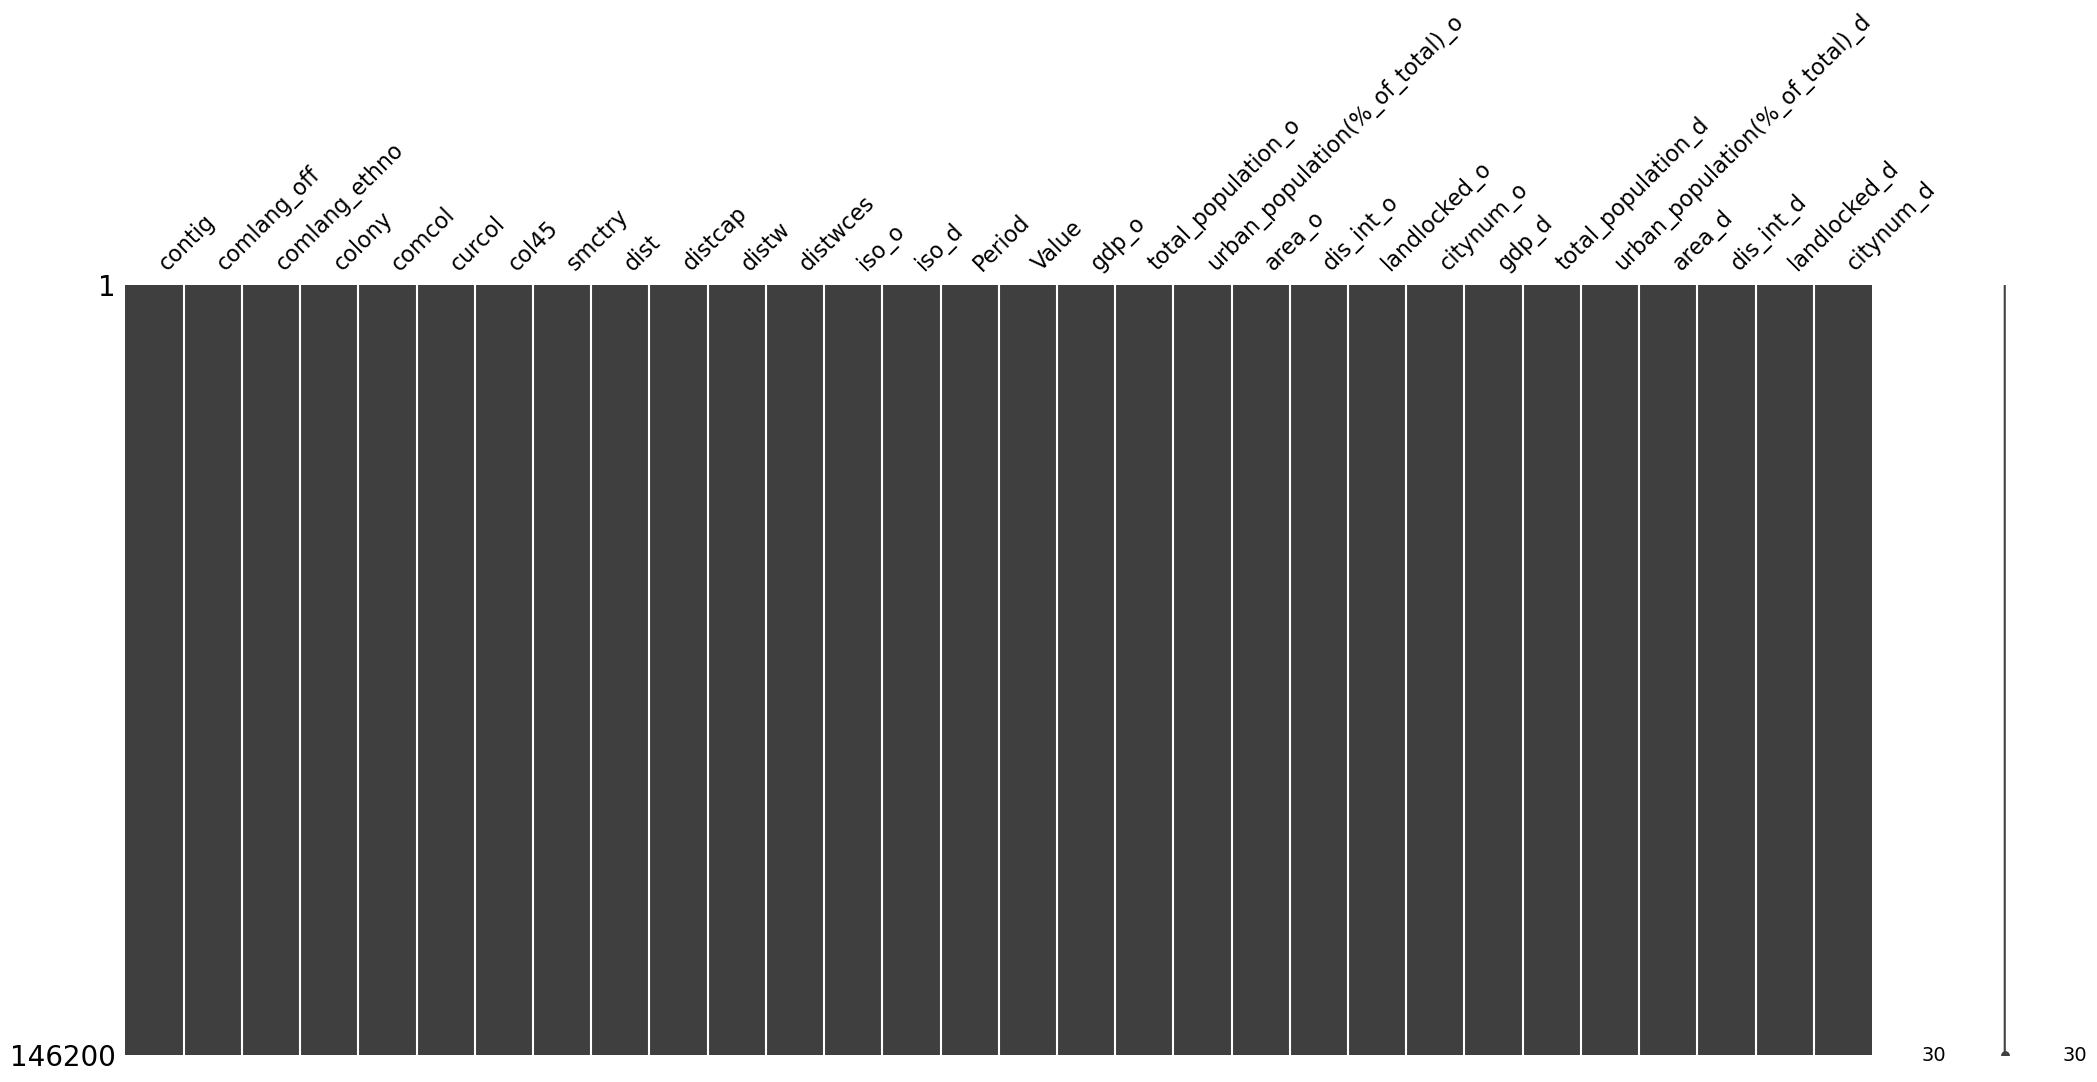

In [25]:
msno.matrix(selected_rows)

In [26]:
to_filter = selected_rows.isna().sum()
to_filter[to_filter > 0]

Series([], dtype: int64)

In [27]:
regr = RangerForestRegressor(importance="impurity", seed=42, n_jobs = -1)

tune_grid = {"mtry": [15, 20, 25], "max_depth": [4, 7, 10]}

rf_random = GridSearchCV(
    regr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [100]:
data_out = pd.DataFrame()
for chunk in chunks:
    data = chunk.copy()

    # Fill missing citynum 
    data.fillna(1, inplace=True)

    # Shift target
    data['Value'] = data.groupby(['iso_o', 'iso_d'])['Value'].shift(-1)

    # Drop because of shift
    data.dropna(inplace=True)
    
    year=min(data['Period'])
    data_train = data[(data["Period"] >= year) & (data["Period"] <= year + 2)]
    data_test = data[(data["Period"] == year + 3)]
    X_train= data_train.drop(['Value'], axis=1)
    X_test= data_test.drop(['Value'], axis=1)
    y_train = data_train['Value']
    y_test = data_test['Value']

    regr.fit(X_train, y_train)
    y_predic = regr.predict(X_test)

    X_test['target'] = y_test
    X_test ['prediction'] = y_predic

    data_out = pd.concat([data_out, X_test])

# calculate RMSE
rmse_nolag_temporal_split = np.sqrt(mean_squared_error(data_out['target'], data_out['prediction']))
print(np.log(rmse_nolag_temporal_split))

22.111973530062443


In [40]:
data_out = pd.DataFrame()
for chunk in chunks:
    data = chunk.copy()

    # Fill missing citynum 
    data.fillna(1, inplace=True)

    # Create lagged values of trade and shift target
    data['lag_value'] = data.groupby(['iso_o', 'iso_d'])['Value'].shift(1)
    data['Value'] = data.groupby(['iso_o', 'iso_d'])['Value'].shift(-1)
    # keep the last year 
    X_predic = data[data['Period'] == max(data['Period'])].drop(['Value'], axis=1)

    # Drop because of shift
    data.dropna(inplace=True)
    
    # Run RF with 5 fold CV + grid search
    X = data.drop(['Value'], axis=1)
    y = data['Value']

    rf_random.fit(X, y)
    y_predic = rf_random.predict(X_predic)

    X_predic ['prediction'] = y_predic


    data_out = pd.concat([data_out, X_predic])


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END min_node_size=4, mtry=15;, score=-4950426953.024 total time=   0.4s
[CV 2/5] END min_node_size=4, mtry=15;, score=-3160360496.930 total time=   0.4s
[CV 3/5] END min_node_size=4, mtry=15;, score=-1582501964.793 total time=   0.4s
[CV 4/5] END min_node_size=4, mtry=15;, score=-1155563124.327 total time=   0.4s
[CV 5/5] END min_node_size=4, mtry=15;, score=-11444795378.253 total time=   0.4s
[CV 1/5] END min_node_size=4, mtry=20;, score=-3598469507.476 total time=   0.4s
[CV 2/5] END min_node_size=4, mtry=20;, score=-1954783319.515 total time=   0.4s
[CV 3/5] END min_node_size=4, mtry=20;, score=-1311822228.866 total time=   0.4s
[CV 4/5] END .min_node_size=4, mtry=20;, score=-898127794.155 total time=   0.5s
[CV 5/5] END min_node_size=4, mtry=20;, score=-10621167898.742 total time=   0.4s
[CV 1/5] END min_node_size=4, mtry=25;, score=-3590425866.869 total time=   0.4s
[CV 2/5] END min_node_size=4, mtry=25;, score=-

In [45]:
    # Save results
results = pd.DataFrame({
    'year': data_out['Period']+1,
    'iso_o': data_out['iso_o'],
    'iso_d': data_out['iso_d'],
    'prediction': data_out['prediction']
})

results

results.to_csv('trade_prediction.csv')